# Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate
data
_
_
challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1) Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?


2) Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.


3) Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

## Imports

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime


## Load Data

In [187]:
df = pd.read_json('./ultimate_data_challenge.json')
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Data Wrangling

In [188]:
# Investigate dupicates
df[df.duplicated(keep=False)].sort_values(by='signup_date')

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
5958,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
10624,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0


In [189]:
# Remove these duplicates
df.drop_duplicates(inplace=True)

In [190]:
# Check missing data
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

`avg_rating_of_driver`, `phone`, and `avg_rating_by_driver` will need to be investigated.

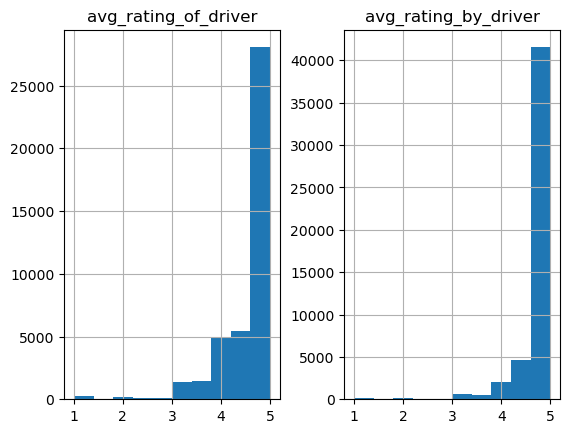

In [191]:
# Impute missing data for 'avg_rating_of_driver' and 'avg_rating_by_driver'
df[['avg_rating_of_driver', 'avg_rating_by_driver']].hist();

Data is clearly skewed for these features so the median will be imputed

In [192]:
# Impute median
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())

In [193]:
# Impute missing data for 'phone'
df['phone'].value_counts()

phone
iPhone     34578
Android    15018
Name: count, dtype: int64

The mode (iPhone) will be imputed for the `phone` feature

In [194]:
df['phone'] = df['phone'].fillna('iPhone')

In [195]:
# Verify
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

No more missing data!

In [196]:
# Investigate shape and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49992 non-null  object 
 1   trips_in_first_30_days  49992 non-null  int64  
 2   signup_date             49992 non-null  object 
 3   avg_rating_of_driver    49992 non-null  float64
 4   avg_surge               49992 non-null  float64
 5   last_trip_date          49992 non-null  object 
 6   phone                   49992 non-null  object 
 7   surge_pct               49992 non-null  float64
 8   ultimate_black_user     49992 non-null  bool   
 9   weekday_pct             49992 non-null  float64
 10  avg_dist                49992 non-null  float64
 11  avg_rating_by_driver    49992 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


The features `city`, `signup_date`, `last_trip_date`, and `phone` will need to be changed from "object" data type for modeling.

`phone` and `city` will be one hot encoded

In [197]:
# city and phone value counts
print(df['city'].value_counts())
print('\n')
print(df['phone'].value_counts())

city
Winterfell        23331
Astapor           16531
King's Landing    10130
Name: count, dtype: int64


phone
iPhone     34974
Android    15018
Name: count, dtype: int64


In [198]:
# one hot encode
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

For our dates, a new feature `retained` will be created which is our feature of interest.<br>
This feature (True: retained, False: not retained) will signify whether the user is active on their 6th month on the system. <br>

The features `signup_date` and `last_trip_date` will then be removed, but its important to note that the month could be retained as a feature to capture any seasonal patterns.

In [199]:
# create new feature 'retained'
df['retained'] = (pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date'])).dt.days > 150

f = df['retained'].value_counts()[False]
t = df['retained'].value_counts()[True]

print(df['retained'].value_counts())
print(str(round(t / (t+f), 3) * 100) + "% of users retained")

retained
False    37794
True     12198
Name: count, dtype: int64
24.4% of users retained


24.4% of users were retained!

In [200]:
# remove signup_date and last_trip_date
df.drop(columns=['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [201]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49992 non-null  int64  
 1   avg_rating_of_driver    49992 non-null  float64
 2   avg_surge               49992 non-null  float64
 3   surge_pct               49992 non-null  float64
 4   ultimate_black_user     49992 non-null  bool   
 5   weekday_pct             49992 non-null  float64
 6   avg_dist                49992 non-null  float64
 7   avg_rating_by_driver    49992 non-null  float64
 8   city_King's Landing     49992 non-null  bool   
 9   city_Winterfell         49992 non-null  bool   
 10  phone_iPhone            49992 non-null  bool   
 11  retained                49992 non-null  bool   
dtypes: bool(5), float64(6), int64(1)
memory usage: 3.3 MB


Looks good!

## Exploratory Data Analysis

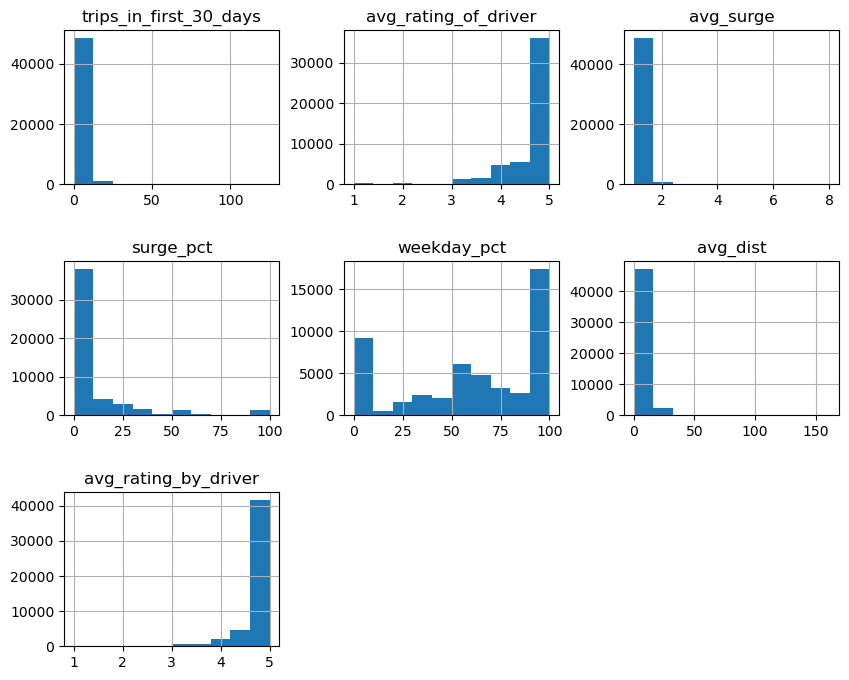

In [ ]:
# Numeric feature visualization
df.hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.5);

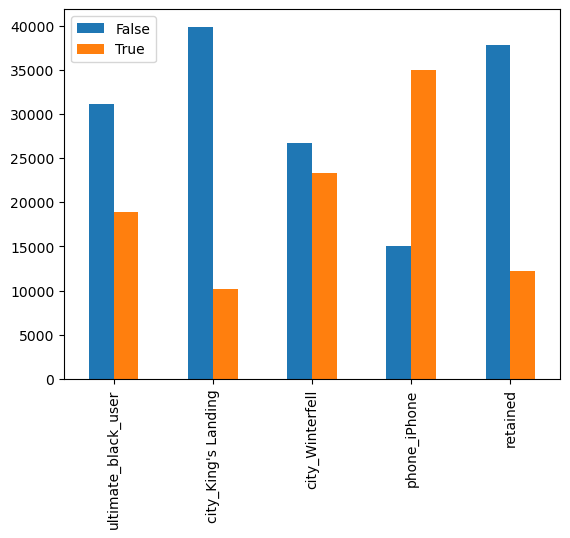

In [213]:
# Boolean feature visualization
df.select_dtypes(include='bool').apply(lambda x: x.value_counts()).T.plot(kind='bar')
plt.show()

In [ ]:
# Statistics on dataframe
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49992.000000,49992.000000,49992.000000,49992.000000,49992.000000,49992.00000,49992.000000
mean,2.278405,4.649988,1.074776,8.850952,60.929833,5.79726,4.779015
std,3.792953,0.575633,0.222352,19.960094,37.078229,5.70761,0.446001
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.42000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.88000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.94000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.96000,5.000000


Everything looks good!

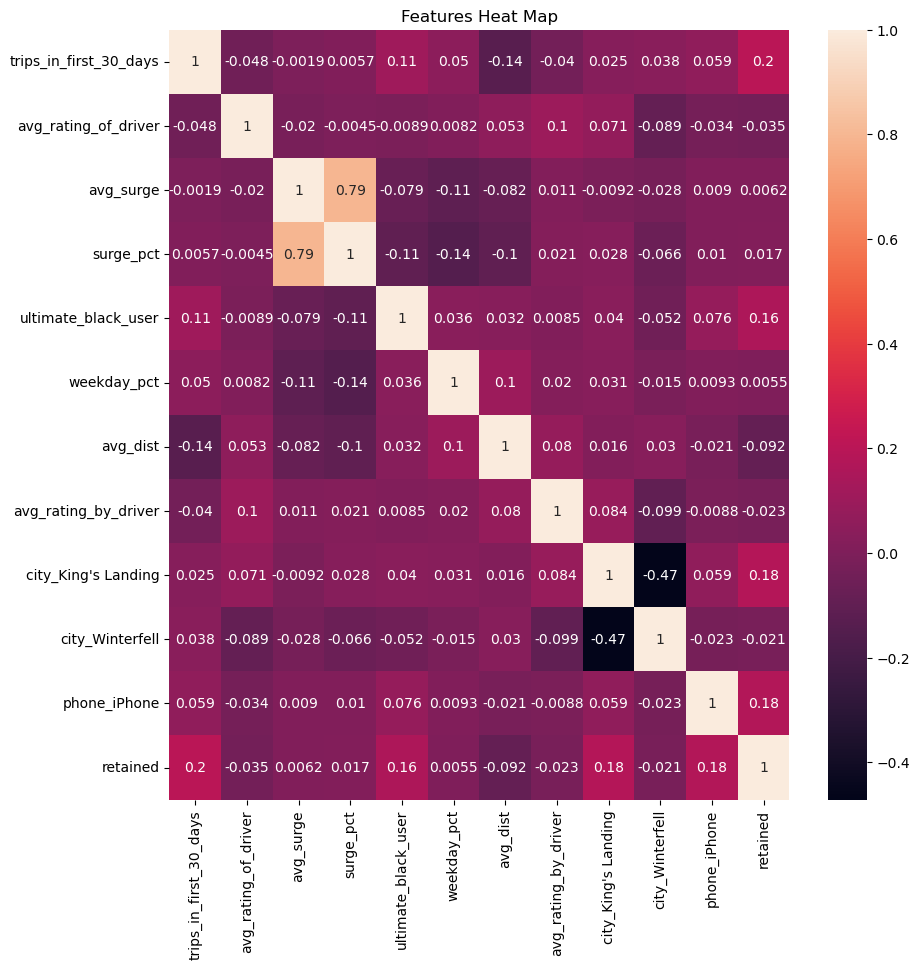

In [ ]:
# Feature heatmap
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.title('Features Heat Map')
plt.show();

`avg_surge`, `surge_pct`, and `weekday_pct` seem to be fairly irrelevant features in correlation with the response variable `retained`.


`trips_in_first_30_days`, `ultimate_black_user`, `city_King's Landing` and `phone_iPhone`, seem to be good indicators for retention.

PCA is unnecessary due to the already low number of features

## Modeling

2) Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

Modeling
Split data
Pick models
Train
Gridsearch for hyperparameters
Score and select model/parameters
Overfit/Underfit?
Data quantity evaluation
Predict
Compare to other


3) Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).


Documentation
Find recommendations